# LSTM

In [8]:
"""
pandas - чтобы работать с таблицами 
numpy - чтобы придумывать новые feature и для разбиения на test и train
random - чтобы перемешивать данные и делить на train и test 
time - чтобы измерить скорость работы алгоритма 
re - чтобы переименовать названия колонок
"""

import pandas as pd 
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sklearn

# LabelEncoder, чтобы обработать категориальные признаки
from sklearn.preprocessing import LabelEncoder
import random 
import re

# Нужно по какой-то причине
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [25]:
# импортирую Tensorflow
import tensorflow as tf
# импортирую Керас
from tensorflow import keras
# и подпокеты
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.optimizers.schedules import ExponentialDecay

# и метрики, функции нормализации и всё для K-фолда
from sklearn.metrics import mean_absolute_error as mae
from sklearn.preprocessing import RobustScaler, normalize
# Импортирую также GroupFold, train_test_split алгоритмы для обучения
from sklearn.model_selection import train_test_split, GroupKFold, KFold

from IPython.display import display

2022-01-30 18:02:56.410227: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-01-30 18:02:56.410254: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [9]:
# Загружаю данные
data_full = pd.read_csv('20211117_600all_IONICON300traces.csv', sep=',')
# Выкидываю onco_after
data_full = data_full[data_full["Group"]!='onco_after']
# Сбрасываю индексы, в которых появились пропуски после удаления onco_after
data_full = data_full.reset_index()
del data_full['index']
# Вывожу таблицу
data_full

,Unnamed: 0,(H3N)+ | 17.026 | 1,(H2O)+ | 18.01 | 2,(H3N)H+ | 18.034 | 3,(H2O)H+ | 19.018 | 4,H3O 18+ | 21.022 | 5,(C2H2)+ | 26.015 | 6,(CHN)+ | 27.01 | 7,(CO)+ | 27.994 | 8,(N2)+ | 28.006 | 9,...,(U)H+ | 239.007 | 317,C6H5I\0AC6H5I | 203.94 | 318,(C18H22)H+ | 239.179 | 319,Heavy_Calibrant | 330.85 | 320,Sample Name,Group,Spectra,CO2_Conz_Set,CO2_Conz_Act,AbsTime
0,0,157,1537,7615,87690,4554,11,228,65,77,...,3,1383,4,74,Schvirkunov_EE_255702021_27042021.h5,Cardiology,1,NaN,1.375,3.702378e+09
1,1,185,1474,7612,88032,4469,7,217,102,138,...,4,1407,7,79,Schvirkunov_EE_255702021_27042021.h5,Cardiology,2,NaN,1.402,3.702378e+09
2,2,180,1454,7987,88030,4448,14,137,102,116,...,6,1361,8,105,Schvirkunov_EE_255702021_27042021.h5,Cardiology,3,NaN,1.441,3.702378e+09
3,3,177,1486,7843,88808,4444,12,123,72,94,...,2,1308,6,84,Schvirkunov_EE_255702021_27042021.h5,Cardiology,4,NaN,1.522,3.702378e+09
4,4,169,1412,7802,88345,4508,8,102,74,90,...,2,1319,8,88,Schvirkunov_EE_255702021_27042021.h5,Cardiology,5,NaN,1.567,3.702378e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17416,58,1760,3990,59670,77753,4106,10,93,72,96,...,6,726,5,74,Djakov_PL_before operation.h5,Control,59,NaN,6.224,3.703128e+09
17417,59,1736,4541,59748,78500,4156,9,100,87,100,...,7,720,14,76,Djakov_PL_before operation.h5,Control,60,NaN,6.200,3.703128e+09
17418,60,1639,4188,59666,66882,4179,16,110,58,77,...,7,753,11,79,Djakov_PL_before operation.h5,Control,61,NaN,6.153,3.703128e+09
17419,61,1716,3891,60416,72560,4095,11,90,84,104,...,6,721,8,79,Djakov_PL_before operation.h5,Control,62,NaN,6.135,3.703128e+09


## We need to make every breath time equal to 60 sek

In [10]:
# Функция предпроцессинга
# Обрезаю записи всех пациентов до 60 секунд, если они длиннее
# Добавляю новые колонки и так далее
def preprocessing(df):    
    del df['Unnamed: 0'] # обрезаю ненужный столбец
    print('Before everything (drop Unnamed)', df.shape) 
    
    # Функция для добавления idSpectra для каждого пациента, это его id
    # прохожу в цикле по датафрейму и смотря на колонку "Spectra" инкрементирую idSpectra
    def add_ID(df):
        flag = 0 
        ids = []
        for i in range(len(df["Spectra"])): 
            if df["Spectra"][i] == 1: 
                flag += 1
            ids.append(flag) 

        df['idSpectra'] = ids
        return df, flag
    
    # добавляею idSpectra в наш датафрейм
    df, flag = add_ID(df)
    print('flag', flag)
    print('+idSpectra', df.shape) 
    
    df_list = []
    for i in range(flag):
        # если в записи больше 90 элементов, то обрезаю начало и конец до 60 элементов
        if len(df[df['idSpectra'] == i+1]) >= 90: 
            data_new = df[df['idSpectra'] == i+1][17:77]
            data_new['Spectra'] = data_new['Spectra'] - 17
            df_list.append(data_new)
        # если в записи больше 80 элементов, то обрезаю начало и конец до 60 элементов
        elif len(df[df['idSpectra'] == i+1]) >= 80:
            data_new = df[df['idSpectra'] == i+1][10:70]
            data_new['Spectra'] = data_new['Spectra'] - 10
            df_list.append(data_new)
        # если в записи больше 70 элементов, то обрезаю начало и конец до 60 элементов
        elif len(df[df['idSpectra'] == i+1]) >= 70:
            data_new = df[df['idSpectra'] == i+1][5:65]
            data_new['Spectra'] = data_new['Spectra'] - 5
            df_list.append(data_new)
        # если в записи больше 60 элементов, то обрезаю конец так, чтобы в итоге вышло 60 элементов
        elif len(df[df['idSpectra'] == i+1]) >= 60:
            df_list.append(df[df['idSpectra'] == i+1][0:60])
        # если в записи больше 50 элементов, то дополняю до 60, развернув последние элементы и добавив их в конец
        elif len(df[df['idSpectra'] == i+1]) >= 50:
            a = len(df[df['idSpectra'] == i+1])
            a_60 = 60 - a + 1
            df_list.append(df[df['idSpectra'] == i+1][0:a])
            data_new = df[df['idSpectra'] == i+1][a:a-a_60:-1]
            Spectra_list = [i for i in range((a + 1),61)]
            data_new['Spectra'] = Spectra_list
            df_list.append(data_new)
        
    # собираю датафрейм
    df = pd.concat(df_list)
    # удаляю индексы чтобы не было никаких проблем
    df = df.reset_index()
    del df['index']
    print('every mesurment = 60 sec', df.shape) 
    
    # кодирую нечисловые признаки в числовые с помощью LabelEncoder
    le = LabelEncoder()
    df['TARGET'] = df['Group'].astype('str')
    df['TARGET'] = le.fit_transform(df['TARGET'])
    print(le, le.classes_)
    
    # кодирую нечисловые признаки в числовые с помощью LabelEncoder
    labelencoder = LabelEncoder()
    df['Sampleid'] = df['Sample Name'].astype('str')
    df['Sampleid'] = labelencoder.fit_transform(df['Sampleid'])
#     print(labelencoder.classes_)
    print ('After Adding TARGET, Sampleid: (+2)', df.shape)
    
    
    # Важные колонки, взяты из диссертации Малиновской Людмилы Кирилловны
    important_columns = ['(H3N)+ | 17.026 | 1', '(H2O)+ | 18.01 | 2', \
                    '(H3N)H+ | 18.034 | 3', 'H3O 18+ | 21.022 | 5' , \
                    '(H2O)H+ | 19.018 | 4', '(CO)+ | 27.994 | 8', \
                    '(CH2O)H+ | 31.018 | 21', 'O2+ | 31.989 | 25', \
                    'O2 17+ | 32.989 | 28', '(C3H7)+ | 43.054 | 46', \
                    '(CO2)+ | 43.989 | 47', '(NO2)+ | 45.992 | 52', \
                    '(C2H6O)H+ | 47.049 | 56', '(O3)+ | 47.984 | 58', \
                    '(CH3Cl)H+ | 51.0 | 61', '(C3H6O)H+ | 59.049 | 70', '(C2H4O2)H+ | 61.028 | 72', \
                    '(C3H8O2)H+ | 77.06 | 86', '(C3H6O3)H+ | 91.039 | 112', \
                    '(C8H10)H+ | 107.086 | 150', '(Xe)+ | 127.903 | 211', \
                    'propylbutanoateH+ | 131.107 | 222', 'menthol/H2OH+ | 139.148 | 236', \
                    'ethzlhexanoateH+ | 145.122 | 239', 'menthoneH+ | 155.142 | 256', \
                    'mentholH+ | 157.159 | 257', 'CO2_Conz_Act']
    
    # Добавляю дополнительные признаки в наш датасет на основе важных колонок из диссертации
    # добавляю максимальное значение, среднее значение и прочее
    for name in important_columns:
        df[name + 'max'] = df.groupby(['idSpectra'])[name].transform('max')
        df[name + 'mean'] = df.groupby(['idSpectra'])[name].transform('mean')
        df[name + 'min'] = df.groupby(['idSpectra'])[name].transform('min')
        df[name + 'cumsum'] = df.groupby(['idSpectra'])[name].transform('cumsum')
        df[name + 'median'] = df.groupby('idSpectra')[name].transform('median')
    print ('After Adding important features: (+ 135)', df.shape)
    
    print(df[['TARGET', 'Group']].value_counts())
    # удаляю ненужные колонки
    del df['CO2_Conz_Set']
    del df['Sample Name']
    del df['Group']
    
    # Меняем невалидные названия колонок, чтобы LSTM не сломалась 
    df = df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
    
    # Заполняем пропуски нулями
    df = df.fillna(0)     

    # В итоге столько колонок:
    print ('full data frame size after preprocessing', df.shape)
    return df, le, labelencoder

In [11]:
data, leTarget, leSample = preprocessing(data_full)

Before everything (drop Unnamed) (17421, 326)
flag 255
+idSpectra (17421, 327)
every mesurment = 60 sec (14760, 327)
LabelEncoder() ['Cardiology' 'Control' 'onco']
After Adding TARGET, Sampleid: (+2) (14760, 329)


/tmp/ipykernel_1049660/3473593073.py:98: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name + 'cumsum'] = df.groupby(['idSpectra'])[name].transform('cumsum')
/tmp/ipykernel_1049660/3473593073.py:99: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name + 'median'] = df.groupby('idSpectra')[name].transform('median')
/tmp/ipykernel_1049660/3473593073.py:95: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all colum

After Adding important features: (+ 135) (14760, 464)
TARGET  Group     
2       onco          6540
0       Cardiology    5940
1       Control       2280
dtype: int64
full data frame size after preprocessing (14760, 461)


In [15]:
# Наши target классы
leTarget.classes_

array(['Cardiology', 'Control', 'onco'], dtype=object)

### Good test_train_permutation_split

In [26]:
# Разбиваю выборку на трейн и тест,
# учитывая что каждый из экспериментов должен попасть
# либо в train, либо в test, либо в train;  должен попасть целиком
def permutation(df):
    # группирую по idSpectra - то есть по id пациентов
    groups = [df for _, df in df.groupby('idSpectra')]
    # перемешиваю
    random.shuffle(groups)
    # делаю датасет
    df = pd.concat(groups)
    return df

# функция для разбивки данных на train и test используя permutation
def split_data(df):
    v = np.unique(df['idSpectra'].value_counts().sort_index().index)
    ids_ = list(v)
    random.shuffle(ids_)
    ids_ = ids_[:int(len(df['idSpectra'].value_counts())*0.1)]

    test_df = df.loc[df['idSpectra'].isin(ids_)]
    train_df = df.loc[~df['idSpectra'].isin(ids_)]
    test_df = permutation(test_df)
    train_df = permutation(train_df)
    targets = train_df['TARGET'].to_numpy().reshape(-1, 60)
    X_train = train_df.drop(['TARGET'], axis=1)
    X_test = test_df.drop(['TARGET'], axis=1)
    y_test = test_df['TARGET'].to_numpy().reshape(-1, 60)
    
    return X_train, targets, X_test, y_test

In [27]:
# разбиваю данные на train и test
X_train, y_train, X_test, y_test = split_data(data)

In [28]:
X_train.shape[-2:]

(13320, 460)

In [29]:
# Масштабирую характеристики с помощью статистики, устойчивой к выбросам
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html
RS = RobustScaler()
print ('X_train.shape :', X_train.shape)
train = RS.fit_transform(X_train)
print('train.shape : ', train.shape)
print ('X_test.shape : ',X_test.shape)
test = RS.transform(X_test)
print('test.shape : ', test.shape)

X_train.shape : (13320, 460)
train.shape :  (13320, 460)
X_test.shape :  (1440, 460)
test.shape :  (1440, 460)


In [30]:
# делаю reshape перед подачей в нейронную сеть
train = train.reshape(-1, 60, train.shape[-1])
test = test.reshape(-1, 60, train.shape[-1])
print(train.shape)
print(test.shape)
print(y_train.shape)
print(y_test.shape)

(222, 60, 460)
(24, 60, 460)
(222, 60)
(24, 60)


In [32]:
from numpy.random import seed
seed(42)
from tensorflow.random import set_seed
set_seed(42)

In [36]:
EPOCH = 100 # количество эпох
BATCH_SIZE = 128 # размер батча
test_preds = []

# LSTM-модель на керасе
model = keras.models.Sequential([
    keras.layers.Input(shape=train.shape[-2:]),
    keras.layers.Bidirectional(keras.layers.LSTM(300, return_sequences=True)),
    keras.layers.Bidirectional(keras.layers.LSTM(250, return_sequences=True)),
    keras.layers.Bidirectional(keras.layers.LSTM(150, return_sequences=True)),
    keras.layers.Bidirectional(keras.layers.LSTM(100, return_sequences=True)),
    keras.layers.Dense(50, activation='selu'),
    keras.layers.Dense(1),
])
model.compile(optimizer="adam", loss="mae") # добавляю оптимайзер и лосс функцию
# добавляю lr шедуллер
scheduler = ExponentialDecay(1e-3, 400*((len(train)*0.8)/BATCH_SIZE), 1e-5)
lr = LearningRateScheduler(scheduler, verbose=1)
es = EarlyStopping(monitor="val_loss", patience=15, verbose=1, mode="min", restore_best_weights=True)

# обучаю модель
history = model.fit(train, y_train, epochs=EPOCH, batch_size=BATCH_SIZE, callbacks=[lr], validation_split = 0.1, validation_data=(test, y_test))
# model.save('RNN Weights 300 epoch')
test_preds.append(model.predict(test).squeeze().reshape(-1, 1).squeeze())


Epoch 00001: LearningRateScheduler setting learning rate to tf.Tensor(0.001, shape=(), dtype=float32).
Epoch 1/100
2/2 [==============================] - 13s 3s/step - loss: 1.2774 - val_loss: 1.0060 - lr: 0.0010

Epoch 00002: LearningRateScheduler setting learning rate to tf.Tensor(0.0009794697, shape=(), dtype=float32).
Epoch 2/100
2/2 [==============================] - 2s 930ms/step - loss: 0.9624 - val_loss: 0.6637 - lr: 9.7947e-04

Epoch 00003: LearningRateScheduler setting learning rate to tf.Tensor(0.00095936086, shape=(), dtype=float32).
Epoch 3/100
2/2 [==============================] - 2s 925ms/step - loss: 0.5545 - val_loss: 0.5687 - lr: 9.5936e-04

Epoch 00004: LearningRateScheduler setting learning rate to tf.Tensor(0.0009396649, shape=(), dtype=float32).
Epoch 4/100
2/2 [==============================] - 2s 956ms/step - loss: 0.4228 - val_loss: 0.5071 - lr: 9.3966e-04

Epoch 00005: LearningRateScheduler setting learning rate to tf.Tensor(0.00092037325, shape=(), dtype=fl

In [39]:
# печатаю точность модели
print("Right guessed: {} from {}".format((np.round(model.predict(test).squeeze().reshape(-1, 1).squeeze()) == y_test.squeeze().reshape(-1, 1).squeeze()).sum(), len(model.predict(test).squeeze().reshape(-1, 1).squeeze())))
print(f"Accuracy: {(np.round(model.predict(test).squeeze().reshape(-1, 1).squeeze()) == y_test.squeeze().reshape(-1, 1).squeeze()).sum() / len(y_test.squeeze().reshape(-1, 1).squeeze())}")

Right guessed: 970 from 1440
Accuracy: 0.6736111111111112


In [40]:
from sklearn.metrics import classification_report, multilabel_confusion_matrix

targets = y_test.squeeze().reshape(-1, 1).squeeze()
preds = np.round(model.predict(test).squeeze().reshape(-1, 1).squeeze())

print (classification_report(targets, preds, target_names=leTarget.classes_))

              precision    recall  f1-score   support

  Cardiology       0.69      0.63      0.66       420
     Control       0.15      0.33      0.21       180
        onco       0.97      0.77      0.86       840

    accuracy                           0.67      1440
   macro avg       0.60      0.58      0.57      1440
weighted avg       0.78      0.67      0.72      1440



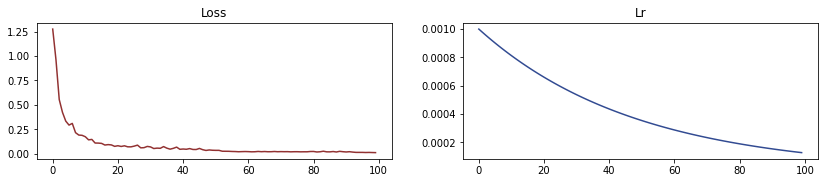

In [44]:
# строю графики

# plt.figure(figsize=(20,8))
fig, (ax1, ax2) = plt.subplots(1, 2)

fig = plt.gcf()
fig.set_size_inches(14, 2.5)

# fig.suptitle('LSTM')
ax1.plot(range(len(history.history["loss"])), history.history["loss"], c="#923232")
ax2.plot(range(len(history.history["lr"])), history.history["lr"], c="#324B92")

ax1.set_title("Loss")
ax2.set_title("Lr")

plt.plot()
plt.savefig("lstm_results.png")